# Multivariate Generalized Gaussian Spatial Model

## Generative Model with Stochastic representation: $\mathbf{x} = \tau \Sigma^{1/2} \mathbf{u}$
1. $\mathbf{u} \in \mathbb{R}^2$ is a random vector sampled from a unit circle
2. Scatter matrix $\Sigma = m \mathbf{M}$
3. Shape parameter $\beta$
4. $\tau^{2 \beta} \sim \Gamma(\frac{p}{2 \beta}, 2)$

In [4]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.stats import special_ortho_group


def random_scatter(m=1, p=2):
    M = np.random.rand(p, p)
    M = 0.5 * (M + M.T)
    return m * M / M.trace()


class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, beta, p=2):
        self._p = p
        self._mu = mu
        self._beta = beta
        self.Sigma = Sigma

    @property
    def dim(self):
        return self._p

    @dim.setter
    def dim(self, val):
        self._p = val

    @property
    def mu(self):
        return self._mu

    @mu.setter
    def mu(self, val):
        self._mu = val

    @property
    def Sigma(self):
        return self._Sigma

    @Sigma.setter
    def Sigma(self, val):
        if val:
            self._Sigma = val
        else:
            self._Sigma = random_scatter(1, self._p)

    @property
    def beta(self):
        return self._beta

    @beta.setter
    def beta(self, val):
        self._beta = val

    def sample(self, n_samples=1000, noise_level=0):
        phi = 2 * np.pi * np.random.random(n_samples)
        u = np.array([np.cos(phi), np.sin(phi)]) + self._mu[:, np.newaxis]
        tau = np.power(
            np.random.gamma(0.5 * self._p / self._beta, 2, n_samples), 0.5 / self._beta
        )
        x = tau * np.matmul(np.sqrt(self._Sigma), u)
        R = special_ortho_group.rvs(self._p)
        x = np.matmul(R, x)
        if noise_level > 0:
            mu = self._mu[:, np.newaxis]
            sigma = np.std(x, axis=1)[:, np.newaxis]
            x += sigma * np.random.randn(self._p, x.shape[1]) + mu

        return x

    def pdf(self, X):
        d = X.shape[1]
        diff = X - self._mu
        exponent = -0.5 * np.sum(
            np.power(np.dot(diff, np.linalg.inv(self._Sigma)), 2), axis=1
        )
        exponent = np.power(1 + exponent / self._beta, -(self._beta + d) / 2)
        return np.prod(exponent)

    def log_likelihood(self, X):
        return np.sum(np.log(self.pdf(X)))


def estimate_params(X):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    beta0 = 3.0
    model = MultiVarGenGaussian(mu0, Sigma0, beta0)
    res = minimize(lambda beta: -model.log_likelihood(X), beta0, method="BFGS")
    beta_hat = res.x[0]
    model.beta = beta_hat
    return model

### Animate Sampling Process

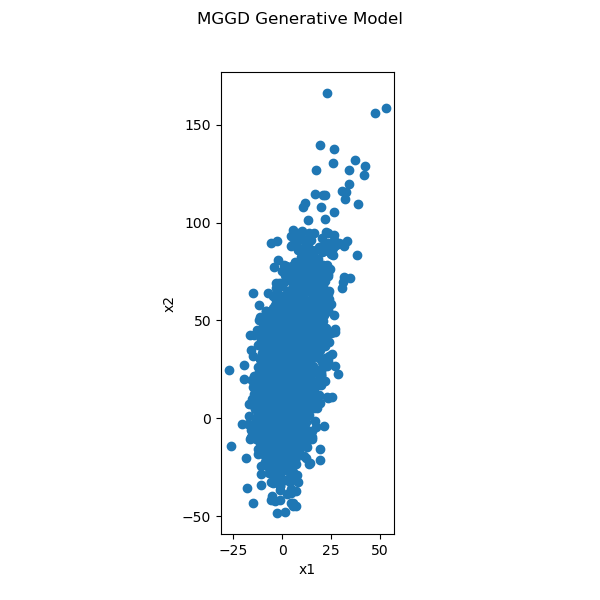

In [5]:
mvgg = MultiVarGenGaussian(mu=np.random.rand(2) * 10 - 5, Sigma=None, beta=0.5, p=2)
x = mvgg.sample(2000, 0.25)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
dots = ax.scatter(x[0, :], x[1, :])


def init():
    x = mvgg.sample(2000, 0.25)
    dots.set_offsets(x.T)
    return dots


def update(frame):
    x = mvgg.sample(2000, 0.25)
    dots.set_offsets(x.T)
    ax.set_xlim(x[0, :].min() - 1, x[0, :].max() + 1)
    ax.set_ylim(x[1, :].min() - 1, x[1, :].max() + 1)

    return dots


ani = FuncAnimation(
    fig, update, repeat=False, frames=10, interval=400, init_func=init, blit=True
)

plt.suptitle("MGGD Generative Model")
plt.show()

## Neuronal Multivariate Generalized Gaussian Process (NMGGP)

In [16]:
%matplotlib widget

import matplotlib.pyplot as plt
import nengo
import numpy as np
from TouchDataset import TouchDataset

# Prepare dataset
dataset = TouchDataset(
    filepath="../data/touch.pkl", noise_level=0.25, scope=(-1.0, 1.0)
)
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.5)
height, width = X_train[0].shape
n_dims = height * width

# Simulation parameters
dt = 1e-3
duration = (len(X_train) - 1) * dt


def input_func(t):
    index = int(t // dt)
    sample = X_train[index]
    return sample.flatten()


# Create the Nengo model
with nengo.Network(label="MGGD") as model:
    stim = nengo.Node(input_func)
    inp = nengo.Ensemble(n_neurons=stim.size_out, dimensions=n_dims)
    hidden = nengo.Ensemble(n_neurons=36, dimensions=inp.size_out)
    out = nengo.Ensemble(n_neurons=16, dimensions=hidden.size_out)
    
    nengo.Connection(stim, inp)
    nengo.Connection(inp, hidden)
    nengo.Connection(hidden, out)

    # Define probes
    inp_probe = nengo.Probe(inp, synapse=0.01)
    inp_spikes = nengo.Probe(inp.neurons)
    out_probe = nengo.Probe(out, synapse=0.01)
    out_spikes = nengo.Probe(out.neurons)

# Simulate the network
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(duration)

### Plot results

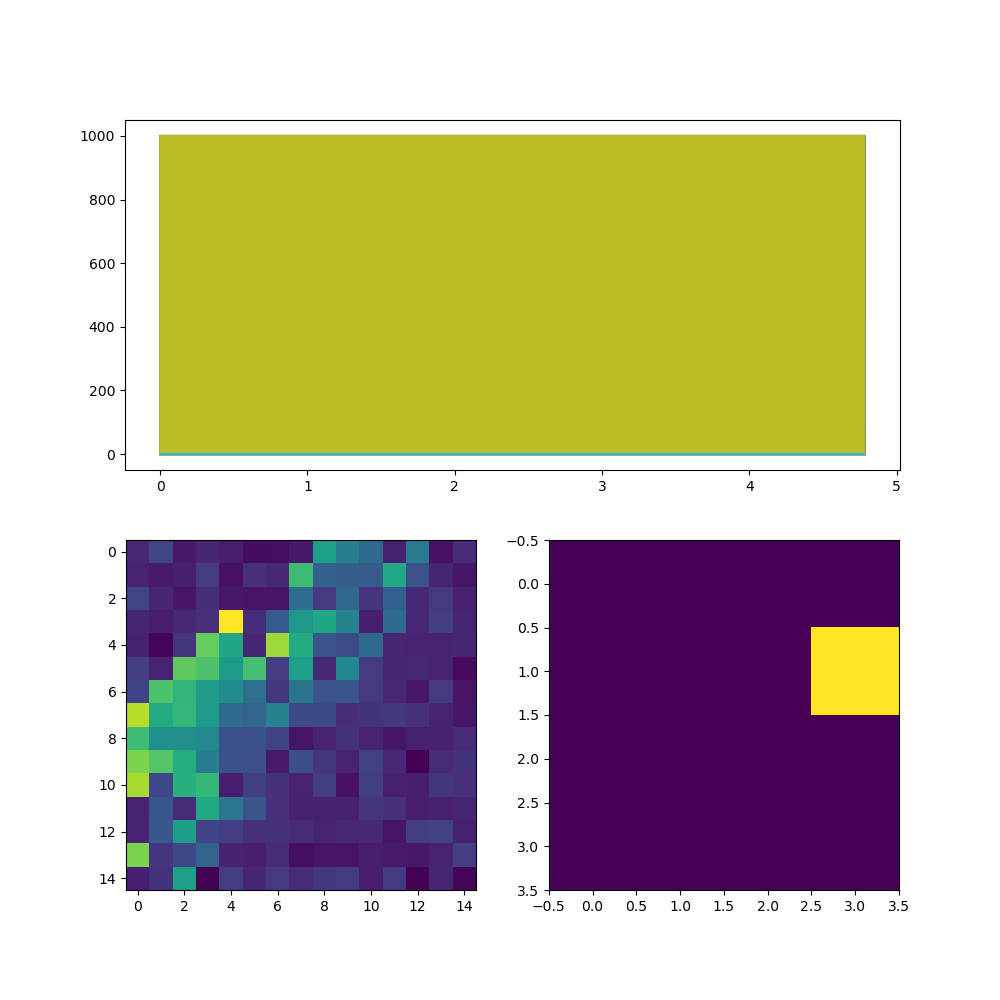

In [21]:
index = 1000
plt.close("all")
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot(211)
ax0.plot(sim.trange(), sim.data[out_spikes][:, 0:10])
ax1 = plt.subplot(223)
ax1.imshow(X_train[index])
ax2 = plt.subplot(224)
ax2.imshow(sim.data[out_spikes][index].reshape((4, 4)))
plt.show()